In [ ]:
""" the original scale """

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
print(tf.__version__)

2.8.0


In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from keras.models import Sequential

In [4]:
# set up a global plt style for the script
# plt.style.use('classic')
plt.rcParams.update({
        "font.size": 9,
        "text.usetex": True,
        "font.family": "serif",
        "figure.figsize": (4, 3),
        "legend.fontsize": 'medium',
        })

In [5]:
%matplotlib widget

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# get path of the directory in which your script is running
ref_path = os.path.abspath('')
ref_path = pathlib.Path(ref_path).resolve().parents[1]
ref_path

PosixPath('/home/yuchen/work_leslie/KTP_Croud')

In [8]:
os.chdir(ref_path)


In [9]:
os.getcwd()

'/home/yuchen/work_leslie/KTP_Croud'

# import the data

In [10]:
dataset = pd.read_csv('data/raw/weekly_media_sample.csv', header=0,)
dataset.drop(columns='X', inplace=True)

In [11]:
time_axis = dataset.pop('DATE')

In [12]:
dataset.head()

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
0,2754371.667,167687.6,95463.66667,228213.98740,8125009,19401.65
1,2584276.667,214600.9,0.00000,34258.57351,7901549,14791.00
2,2547386.667,0.0,3404.00000,127691.26130,8300197,14544.00
3,2875220.000,625877.3,132600.00000,84014.72031,8122883,2800.00
4,2215953.333,0.0,0.00000,20687.47816,7105985,15478.00


In [13]:
dataset.shape

(208, 6)

In [14]:
''' specify the split '''

train_val_split = 200

In [15]:
# double check

dataset.iloc[train_val_split-1]

revenue             2.575148e+06
media1_S            0.000000e+00
media2_S            1.095323e+05
media3_S            3.992652e+04
competitor_sales    8.116568e+06
newsletter          7.041700e+04
Name: 199, dtype: float64

In [16]:
train_dataset = dataset[:train_val_split]
test_dataset = dataset[train_val_split:]

In [17]:
train_dataset.shape

(200, 6)

In [18]:
test_dataset

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
200,2510951.667,208627.1,0.00000,0.0000,7702931,50905.00
201,2275620.000,0.0,147067.00000,0.0000,7060116,79428.00
202,2505161.667,144479.6,0.00000,415793.8103,7603752,58284.00
203,2456240.000,0.0,153723.66670,0.0000,7612762,28157.00
204,2182825.000,154917.6,0.00000,133624.5755,6701667,10644.00
205,2377706.667,21982.5,17476.00000,0.0000,7688920,9597.00
206,2732825.000,22453.0,24051.33333,0.0000,8815710,90189.00
207,2767788.333,0.0,0.00000,366190.7594,9067759,19401.65


In [19]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('revenue')
test_labels = test_features.pop('revenue')

In [20]:
train_features.shape

(200, 5)

In [21]:
train_features.head()

,media1_S,media2_S,media3_S,competitor_sales,newsletter
0,167687.6,95463.66667,228213.98740,8125009,19401.65
1,214600.9,0.00000,34258.57351,7901549,14791.00
2,0.0,3404.00000,127691.26130,8300197,14544.00
3,625877.3,132600.00000,84014.72031,8122883,2800.00
4,0.0,0.00000,20687.47816,7105985,15478.00


In [22]:
train_labels.shape

(200,)

In [23]:
train_features = train_features.values
test_features = test_features.values

train_labels = train_labels.values
test_labels = test_labels.values

In [24]:
train_features[-1]

array([      0.     ,  109532.3333 ,   39926.52158, 8116568.     ,
         70417.     ])

In [25]:
test_labels.shape

(8,)

In [26]:
# normalization

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 113018.484   27371.74    62366.473 5448277.5     21548.955]]


In [27]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 167687.6    95463.67  228213.99 8125009.     19401.65]]

Normalized: [[ 0.25  1.43  1.84  1.3  -0.12]]


# construct BNN model

### Construct a BNN model

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    # number of parameters
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
        lambda t : tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
                                  reinterpreted_batch_ndims=1))
    ])
    return prior_model

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size 
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n, convert_to_tensor_fn=tfd.Distribution.sample)
    ])
    return posterior_model

In [ ]:
N=200

In [ ]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    # normalizer,
    tfpl.DenseVariational(units=64,
                          input_shape=(5,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/N,
                          activation='relu'),
    tfpl.DenseVariational(units=64,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/N,
                          activation='relu'),    
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight = 1/N),
    tfpl.IndependentNormal(1), # scalar regression
])


In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
model.compile(
    loss=nll, 
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"])

In [ ]:
model.summary()

In [ ]:
# # Train the model

# BNN_history = model.fit(
#     train_features,
#     train_labels,
#     # validation_data = (test_features.values, test_labels.values),
#     verbose=1, 
#     epochs=300
# )

In [ ]:
plot_loss(BNN_history)

### just a simple DNN model as reference

In [32]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError(
    name='mean_absolute_percentage_error', dtype=None
    )])
    return model

In [29]:
# # without normalization

# dnn_model = keras.Sequential([
#   layers.Dense(128, activation='relu', input_shape=(5,)),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(1)
# ])

# dnn_model.compile(loss='mae',
#             optimizer=tf.keras.optimizers.Adam(),
#             metrics=[tf.keras.metrics.MeanAbsolutePercentageError(
#     name='mean_absolute_percentage_error', dtype=None
# )])

In [33]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 128)               768       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,420
Trainable params: 17,409
Non-trainable params: 11
_________________________________________________________________


In [37]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1,
    epochs=1000)

Epoch 1/1000
5/5 [==============================] - 0s 22ms/step - loss: 69253603328.0000 - mean_absolute_percentage_error: 8.4079 - val_loss: 80777887744.0000 - val_mean_absolute_percentage_error: 11.0219
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 69246910464.0000 - mean_absolute_percentage_error: 8.4119 - val_loss: 80732618752.0000 - val_mean_absolute_percentage_error: 11.0169
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 69255618560.0000 - mean_absolute_percentage_error: 8.4004 - val_loss: 80695787520.0000 - val_mean_absolute_percentage_error: 10.9914
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 69236039680.0000 - mean_absolute_percentage_error: 8.3976 - val_loss: 80699891712.0000 - val_mean_absolute_percentage_error: 11.0034
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 69249974272.0000 - mean_absolute_percentage_error: 8.3943 - val_loss: 80714219520.0000 - val_mean_absol

In [38]:
from src.modelling.modules import plot_history_info

In [39]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

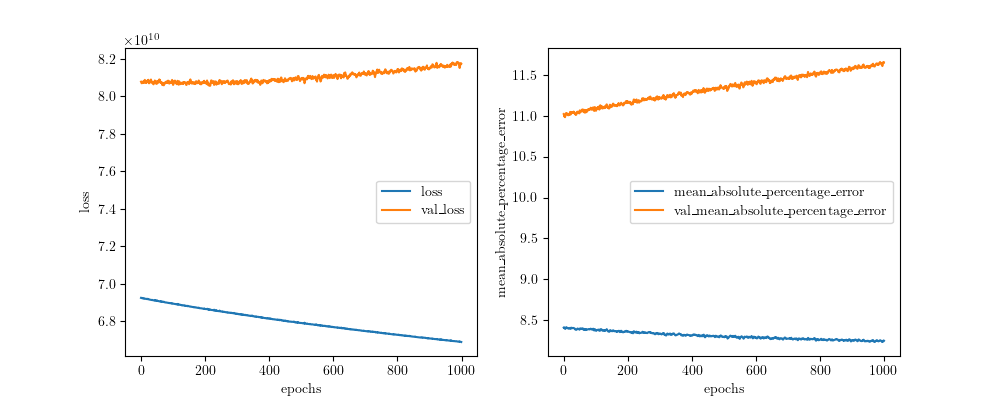

In [40]:
plot_history_info(history)

# back-up

In [ ]:
# # Define the prior weight distribution -- all N(0, 1) -- and not trainable

# def prior(kernel_size, bias_size, dtype=None):
#     # number of parameters
#     n = kernel_size + bias_size
#     prior_model = Sequential([
#         tfpl.DistributionLambda(
#         lambda t : tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
#                                   reinterpreted_batch_ndims=1))
#     ])
#     return prior_model


# # Define variational posterior weight distribution -- multivariate Gaussian

# def posterior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size 
#     posterior_model = Sequential([
#         tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
#         tfpl.IndependentNormal(n, convert_to_tensor_fn=tfd.Distribution.sample)
#     ])
#     return posterior_model

# # define the "negative log likelihood" as loss function
# def nll(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

In [ ]:
# # Create probabilistic regression with one hidden layer, weight uncertainty

# model = Sequential([
#     normalizer,
#     tfpl.DenseVariational(
#         units= 16,
#         input_shape=(5,),
#         make_prior_fn=prior,
#         make_posterior_fn=posterior,
#         kl_weight=1/N,
#         activation='relu'),   
#     tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
#                           make_prior_fn=prior,
#                           make_posterior_fn=posterior,
#                           kl_weight=1/N),
#     tfpl.IndependentNormal(1),
# ])


In [ ]:
# ''' compile and train '''

# # model.compile(
# #     loss=nll, 
# #     optimizer=tf.keras.optimizers.Adam(),
# #     metrics=["mae"])

# model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(), metrics=['mae'])

# # Train the model

# BNN_history = model.fit(
#     train_features,
#     train_labels,
#     validation_data = (test_features, test_labels),
#     batch_size = 32,
#     verbose=1, 
#     epochs=300,
# )

# plot_history_info(BNN_history)